# Homework 2 - Writeup

# 1. More Backpropagation

## 1.1 backprop thorugh a DAG of modules

Our goal is to express $\frac{\partial E}{\partial x_{1}} $ and $\frac{\partial E}{\partial x_{2}}$ given $\frac{\partial E}{\partial y}$. 

We start by breaking up the expression using the chain rule:
$$ \frac{\partial E}{\partial x_{1}} = \frac{\partial E}{\partial y}\frac{\partial y}{\partial \sigma(x_{1})}\frac{\partial \sigma(x_1)}{\partial x_{1}}$$

By symmetry the same expression hold for $x_2$ if we replace $x_1$ by $x_2$.

The first fraction in the expression is assumed to be given by the question. The last fraction is fimilar to us from the last homework. It is simply the following: 
$$ \frac{\partial \sigma(x_{1})}{\partial x_{1}} = \frac{e^{-x_{1}}}{(1 + e^{-x_{1}})^2} $$

Therefore we only need to calculate $\frac{\partial y}{\partial \sigma(x_{1})}$

$$\frac{\partial y}{\partial \sigma(x_{1})} = \frac{\partial max(\sigma(x_{1}),\sigma(x_{2}))+min(\sigma(x_{1}),\sigma(x_{2}))}{\partial \sigma(x_{1}))} $$

Because $y$ is the sum of both the min and max, then regardless of whether $x_1>x_2$ or $x_1<x_2$ both terms will appear in the simplification of the expression. 

$$\frac{\partial y}{\partial \sigma(x_{1})} = \frac{\partial \sigma(x_{1})+\sigma(x_{2})}{\partial \sigma(x_{1}))} = 1$$

By symmetry this is true for $x_2$ as well. 

The only time we can potentially run into trouble is when $x_1==x_2$. when this happens, both $x_2$ and $x_1$ are equally likely to be the result of the max or min functions,  (TO DO --> ask jake!!!) because here gradient cam be either 2 or 0.

$$ \frac{\partial x_{out}}{\partial x_{in}} = \frac{e^{-x_{in}}}{(1 + e^{-x_{in}})^2} $$

## 2.3 Visualization

### First Layer Visualization (section 2.3.1.a)

In [2]:
require 'nn'
require 'cunn'

function loadModel(modelFilename)
   print('Loading model: '..modelFilename)
   local model = torch.load(modelFilename):cuda()
   return model
end

model = loadModel('results/pseudo_8000_noaug/model.small.net')

Loading model: results/pseudo_8000_noaug/model.small.net	


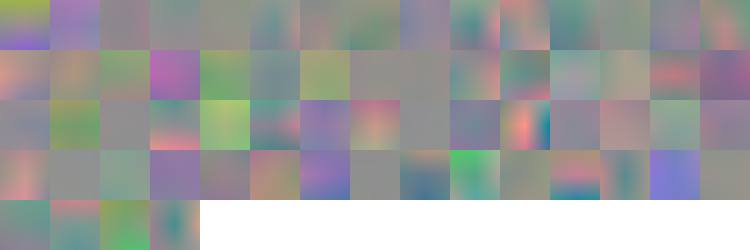

In [3]:
require 'image'

weights = model:get(1).weight:float()

scaledWeights = {}
for i = 1, weights:size(1) do
   scaledWeights[i] = image.scale(weights[i], 50, 50)
end

itorch.image(scaledWeights, {nrow=15})

 64
  3
  3
  3
[torch.LongStorage of size 4]



### Data Augmentation Visualization (section 2.3.1.b)

In [2]:
require 'torch'
require 'image'
require 'nn'
require 'math'
require 'sys'

require 'provider'
require 'augment_data'

In our data augmentation code we've implemented a number a data augmentations:

- we've rotated the images up to 20 degrees, either right or left, and then cropped out the resulting black regions.
- we've randomly changed the hue of the image by +0.1 or -0.1 (by changing it to hsv, changing the h layer, then changing it back to rgb).
- we've translated the image by 12 pixels to the right and downwards, cropped out the black portions and rescaled to original size.
- we've cropped the edge of the image (up to 12 pixels) and scale up to original size.


In practice, during the data augmentation process, we randomly select a subset of these augmentations to apply to our data. (functions available in augment_data.lua). for the purposed of diplaying the we 

In [75]:

--rotate
function rotate(src_image)
    angle_rad = 0.35*torch.uniform()
    --calculate new crop margin
    width = (src_image:size(2))/(math.cos(angle_rad)+math.sin(angle_rad))
    crop_margin = (src_image:size(2)-width)/2
    --choose roation direction
    local new = nil
    if  torch.uniform() > 0.5 then
        new = image.rotate(src_image, angle_rad) -- up to a 20 degree angle    
    else
        new = image.rotate(src_image, -angle_rad) -- up to a 20 degree angle   
    end
    new = image.crop(new,crop_margin,crop_margin,new:size(2)-crop_margin,new:size(3)-crop_margin)
    new = image.scale(new, src_image:size(2), src_image:size(3))
    return new
end

-- change the hue
function change_hue(src_image)
    
    local new = image.rgb2hsv(src_image)
    if torch.uniform() > 0.5 then
        new[1] = new[1]-0.1
    else
        new[1] = new[1]+0.1
    end
    new = image.hsv2rgb(new)

    return new
end


-- tanslate
function translate(src_image)   
    translate_by  = 25
    local new = image.translate(src_image, translate_by, 0)
    new = image.crop(new,translate_by,0,new:size(2),new:size(3))
    new = image.scale(new, src_image:size(2), src_image:size(3))
    return new
end  


-- crop
function crop(src_image) 
    local cropping_pix = 20
    local cropped = image.crop(src_image,cropping_pix,cropping_pix,src_image:size(2)-cropping_pix,src_image:size(3)-cropping_pix)
    new = image.scale(cropped, src_image:size(2), src_image:size(3))
    return new
end

In [76]:
data_filename = 'provider.test.t7'
data_file = io.open(data_filename, 'r')
if data_file ~= nil then
    print("not nill")
    provider = torch.load(data_filename)
end

not nill	


In [77]:
MASTER_TENSOR = torch.Tensor(60,provider.trainData.data:size(2),provider.trainData.data:size(3),provider.trainData.data:size(4))
MASTER_TENSOR[{{1,10}}] = provider.trainData.data[{{1,10},{}}]

In [78]:
--rotate
for img=1, provider.trainData.data[{{1,10},{}}]:size(1) do
    local augmented_tensor = provider.trainData.data[{{1,10},{}}]:clone()
    local src_image = provider.trainData.data[img]
    MASTER_TENSOR[img+10] = rotate(src_image)
    --print(src_image:size())
    MASTER_TENSOR[img+20] = translate(src_image)
    -- change the hue
    MASTER_TENSOR[img+20] = change_hue(src_image)
    MASTER_TENSOR[img+30] = translate(src_image)
    --crop
    MASTER_TENSOR[img+40] = crop(src_image)
    --random combination
    MASTER_TENSOR[img+50] = do_something_redux(src_image)
end

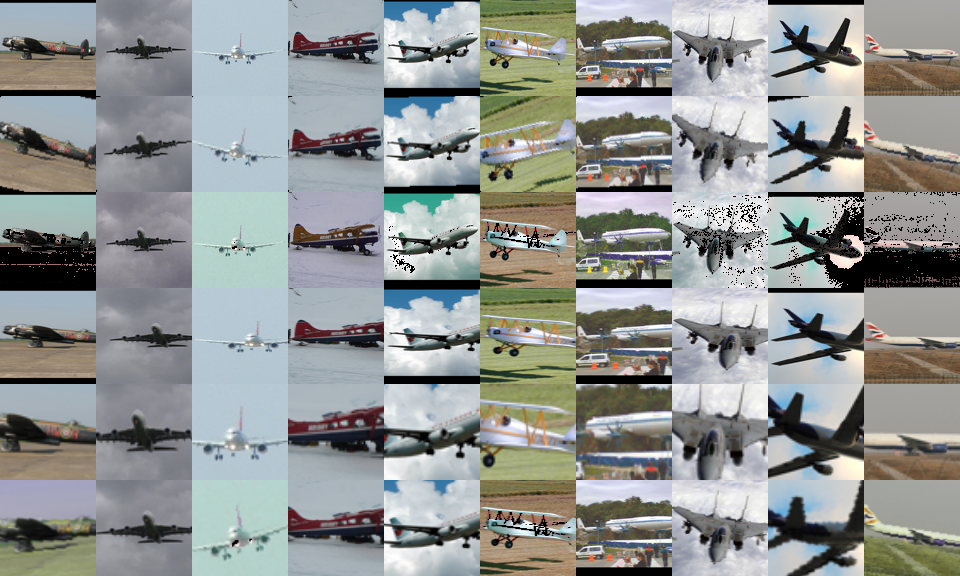

In [79]:
itorch.image(MASTER_TENSOR, {nrow=10})

## 2.4 Evaluation (Model Preformance)

In tackling the mission of improving model performance we've tried both a pre-training approach as well as a unified training approach.

1. **Data Augmentation** - we've followed the most of the suggestion in the 'Discriminative Unsupervised Feature Learning with Convolutional Neural Networks' paper in choosing which data augmentation strategies would be potentially beneficial implement and applied those to the labeled data (http://papers.nips.cc/paper/5548-discriminative-unsupervised-feature-learning-with-convolutional-neural-networks.pdf). Results of data augmentation shown in section 2.3.1.b)

2. **Pre training with Kmeans**  - 
    - First we've convolved a sobel filter with the unnormalized unlabeled data (it is important to apply the sobel filter to the unnormalized version for the image otherwise the result is distorted.)
     - We then examined 3x3 patches from the image once the filter was applied and used a threshold to chose patches with a high mean approximate gradient (to ensure that we are selecting an edge, which would be more information than selecting just a patch of sky for example.) It's important to note that while we chose patches by looked at the convolved image, we stored the corresponding patch from the progonal image. 
     - We then further reduced the number of patched taken from each image by randomly selecting a subset of patches associated with image. This step is motivated by memory constraints, but has the added benefit of ensuring that we select a select a set number of patches from each image.
     - before running kmeans we made sure to normalize the patched both locally as well as using the mean and std from the labeled train data.
     - Next we reshaped each patch to be a 1x(3x3x3) vector and ran kmeans with 1000 iterations and 64 clusters.
     - Lastly we loaded the reshaped the centroids from kmeans and used them to initialize the filters in the first layer of our model.
     
3. **Psuedo Lables** - 